# Packages

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from scipy.stats import multivariate_normal
from scipy import stats
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from scipy.stats import chisquare
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# data load

In [11]:
original_data = pd.read_csv("GAS_original-FS.csv")
synthetic_data = pd.read_csv("synthetic_data-GAN(1).csv")

# kolmogorov - smirnov

In [12]:
# Perform Kolmogorov-Smirnov test
ks_stat, p_value = ks_2samp(original_data.values.flatten(), synthetic_data.values.flatten())
print("Kolmogorov-Smirnov test statistic: ", ks_stat)
print("Kolmogorov-Smirnov test p-value: ", p_value)

Kolmogorov-Smirnov test statistic:  0.19199950525154863
Kolmogorov-Smirnov test p-value:  0.0


# nominal statistical analysis

In [13]:
statso = original_data.describe()
statss = synthetic_data.describe()

# Print the statistics
print("Original Data Stats: ", statso)
print("Synthetic Data Stats : ", statss)

Original Data Stats:         response_address   resp_length  response_memory  resp_write_fun  \
count      97019.000000  97019.000000     97019.000000    97019.000000   
mean           3.719436     26.294654       216.657170        9.298591   
std            1.021543     26.560107        59.504855        2.553856   
min            0.000000     19.000000         0.000000        0.000000   
25%            4.000000     19.000000       233.000000       10.000000   
50%            4.000000     19.000000       233.000000       10.000000   
75%            4.000000     19.000000       233.000000       10.000000   
max            4.000000    123.000000       233.000000       10.000000   

       response_memory_count  resp_read_fun      setpoint  control_mode  \
count           97019.000000   97019.000000  97019.000000  97019.000000   
mean               16.737464       2.449963     24.166607      0.899659   
std                 4.596942       0.893052     14.322356      0.991003   
min        

# Hotelling test + PCA + Mahalanobis distance

In [14]:
original_df = original_data
synthetic_df = synthetic_data
# Remove any columns that are not numerical
original_df = original_df.select_dtypes(include=['number'])
synthetic_df = synthetic_df.select_dtypes(include=['number'])

# Calculate the correlation matrices for the original and synthetic datasets
original_corr = original_df.corr()
synthetic_corr = synthetic_df.corr()

# Perform the Hotelling T^2 test to compare the means of the original and synthetic datasets
# Assumes that the datasets have the same covariance structure
n = len(original_df)
p = len(original_df.columns)
t2 = n * np.dot(np.dot((original_df.mean() - synthetic_df.mean()), np.linalg.inv(
    (original_df.cov() + synthetic_df.cov())/2)), (original_df.mean() - synthetic_df.mean()).T)
F = ((n-p-1)/p) * (n-2) * t2 / (n*(n-2-t2))
p_value = 1 - stats.f.cdf(F, p, n-p-1)

# Perform the Ledoit-Wolf shrinkage estimator to estimate the covariance matrix for each dataset
lw = LedoitWolf().fit(original_df)
original_cov = lw.covariance_
lw = LedoitWolf().fit(synthetic_df)
synthetic_cov = lw.covariance_

# Generate multivariate normal distributions for the original and synthetic datasets
original_dist = multivariate_normal(
    mean=original_df.mean().values, cov=original_cov)
synthetic_dist = multivariate_normal(
    mean=synthetic_df.mean().values, cov=synthetic_cov)

# Compute the Mahalanobis distance between each data point in the original and synthetic datasets
original_mahal = original_dist.rvs(n).T
original_mahal_dist = np.sqrt(
    np.sum(np.square(original_mahal - original_df.T.values), axis=0))
synthetic_mahal = synthetic_dist.rvs(n).T
synthetic_mahal_dist = np.sqrt(
    np.sum(np.square(synthetic_mahal - synthetic_df.T.values), axis=0))

# Perform PCA on the original and synthetic datasets
pca_original = PCA().fit(original_df)
pca_synthetic = PCA().fit(synthetic_df)

# Compute the principal components for each dataset
original_pcs = pca_original.transform(original_df)
synthetic_pcs = pca_synthetic.transform(synthetic_df)

# Calculate the proportion of variance explained by each principal component
original_var_exp = pca_original.explained_variance_ratio_
synthetic_var_exp = pca_synthetic.explained_variance_ratio_

# Compute the Mahalanobis distance between the principal components of the original and synthetic datasets
pca_mahal_dist = np.sqrt(
    np.sum(np.square(original_pcs - synthetic_pcs), axis=1))

# Print out the results
print(f"Hotelling T^2 test p-value: {p_value}")
print(
    f"Original Mahalanobis distance mean: {original_mahal_dist.mean()}, std: {original_mahal_dist.std()}")
print(
    f"Synthetic Mahalanobis distance mean: {synthetic_mahal_dist.mean()}, std: {synthetic_mahal_dist.std()}")


Hotelling T^2 test p-value: 1.0
Original Mahalanobis distance mean: 71.93294661783641, std: 61.92535387848035
Synthetic Mahalanobis distance mean: 34.816881869216644, std: 26.298318889357784


# data describe 

Synthetic data shape: (97019, 10)
Original data shape: (97019, 10)
Synthetic data summary statistics:
        response_address   resp_length  response_memory  resp_write_fun  \
count      97019.000000  97019.000000     97019.000000    97019.000000   
mean           1.149393     48.770014        66.484163        2.889084   
std            0.512040     12.125279        27.071711        1.197392   
min            0.000000     19.000000         0.000000        0.000000   
25%            1.000000     40.000000        47.000000        2.000000   
50%            1.000000     47.000000        63.000000        3.000000   
75%            1.000000     56.000000        83.000000        4.000000   
max            4.000000    123.000000       233.000000       10.000000   

       response_memory_count  resp_read_fun      setpoint  control_mode  \
count           97019.000000   97019.000000  97019.000000  97019.000000   
mean                5.154918       1.983045     39.776456      0.974459   
std  

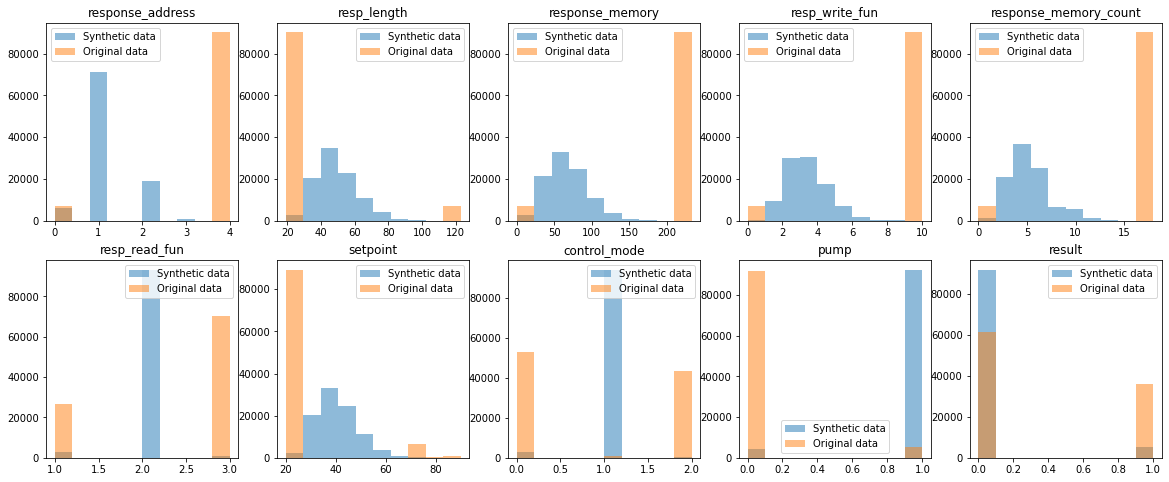

In [15]:
# Perform EDA on datasets

# Check the shape of both dataframes to ensure they have the same number of features and rows
print('Synthetic data shape:', synthetic_data.shape)
print('Original data shape:', original_data.shape)

# Use the describe() method on both dataframes to get the summary statistics of the data
print('Synthetic data summary statistics:\n', synthetic_data.describe())
print('Original data summary statistics:\n', original_data.describe())

# Plot histograms of the features in both dataframes to visualize their distributions
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    ax.hist(synthetic_data.iloc[:, i], alpha=0.5, label='Synthetic data')
    ax.hist(original_data.iloc[:, i], alpha=0.5, label='Original data')
    ax.set_title(synthetic_data.columns[i])
    ax.legend()
plt.show()

# Outlier and MSE values

In [16]:
# Identify any outliers or missing values in the dataframes and handle them appropriately
synthetic_data.isnull().sum()
original_data.isnull().sum()
synthetic_data = synthetic_data.dropna()
original_data = original_data.dropna()

# Split datasets into training and testing sets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    original_data.drop(columns=['result']), original_data['result'], test_size=0.2, random_state=42)
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    synthetic_data.drop(columns=['result']), synthetic_data['result'], test_size=0.2, random_state=42)

# Train and evaluate regression model on original dataset
orig_model = LinearRegression()
orig_model.fit(X_train_orig, y_train_orig)
y_pred_orig = orig_model.predict(X_test_orig)
orig_mse = mean_squared_error(y_test_orig, y_pred_orig)
orig_r2 = r2_score(y_test_orig, y_pred_orig)

# Train and evaluate regression model on synthetic dataset
synth_model = LinearRegression()
synth_model.fit(X_train_synth, y_train_synth)
y_pred_synth = synth_model.predict(X_test_synth)
synth_mse = mean_squared_error(y_test_synth, y_pred_synth)
synth_r2 = r2_score(y_test_synth, y_pred_synth)

# Compare performance metrics of original and synthetic models
print(
    "Original dataset MSE: {:.4f}, R-squared: {:.4f}".format(orig_mse, orig_r2))
print(
    "Synthetic dataset MSE: {:.4f}, R-squared: {:.4f}".format(synth_mse, synth_r2))

Original dataset MSE: 0.1126, R-squared: 0.5153
Synthetic dataset MSE: 0.0069, R-squared: 0.8657


# Regression model score

In [17]:
X_orig = original_data.drop('result', axis=1)
y_orig = original_data['result']
X_syn = synthetic_data.drop('result', axis=1)
y_syn = synthetic_data['result']
# assuming X_orig and y_orig are the original data, and X_syn and y_syn are the synthetic data
X = np.concatenate((X_orig, X_syn), axis=0)
y = np.concatenate((y_orig, y_syn), axis=0)

# define the number of folds
k = 5

# define the model
model = LinearRegression()

# initialize the K-Fold cross-validator
kf = KFold(n_splits=k, shuffle=True)

# initialize the arrays to store the results
r_squared_scores = np.zeros(k)
mse_scores = np.zeros(k)

# loop over the folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # split the data into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # train the model on the training set
    model.fit(X_train, y_train)

    # evaluate the model on the test set
    y_pred = model.predict(X_test)
    r_squared_scores[i] = model.score(X_test, y_test)
    mse_scores[i] = mean_squared_error(y_test, y_pred)

# print the average results
print("Average R-squared score: ", np.mean(r_squared_scores))
print("Average MSE score: ", np.mean(mse_scores))

Average R-squared score:  0.5195530306875654
Average MSE score:  0.08007274052950104


# ML model using Logistic Regression 

In [18]:
# Load the necessary libraries

# Split the original data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(original_data.drop(
    'result', axis=1), original_data['result'], test_size=0.2, random_state=42)

# Train a machine learning model on the original training set
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the performance of the model on the original testing set
original_score = accuracy_score(y_test, model.predict(X_test))

# Split the synthetic data into training and testing sets
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(synthetic_data.drop(
    'result', axis=1), synthetic_data['result'], test_size=0.2, random_state=42)

# Train the same machine learning model on the synthetic training set
syn_model = LogisticRegression()
syn_model.fit(X_syn_train, y_syn_train)

# Evaluate the performance of the model on the synthetic testing set
synthetic_score = accuracy_score(y_syn_test, syn_model.predict(X_syn_test))

# Compare the performance of the model on the testing sets of the original and synthetic data
if original_score > synthetic_score:
    print("The synthetic data is of poor quality.")
elif original_score < synthetic_score:
    print("The synthetic data is of good quality.")
else:
    print("the synthetic data perform as indicated")

The synthetic data is of good quality.


C:\Users\Gautam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
print(synthetic_score)

0.9945887445887446


In [20]:
print(original_score)

0.9232117089259947
